# Assignment 4
### Do three of four.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

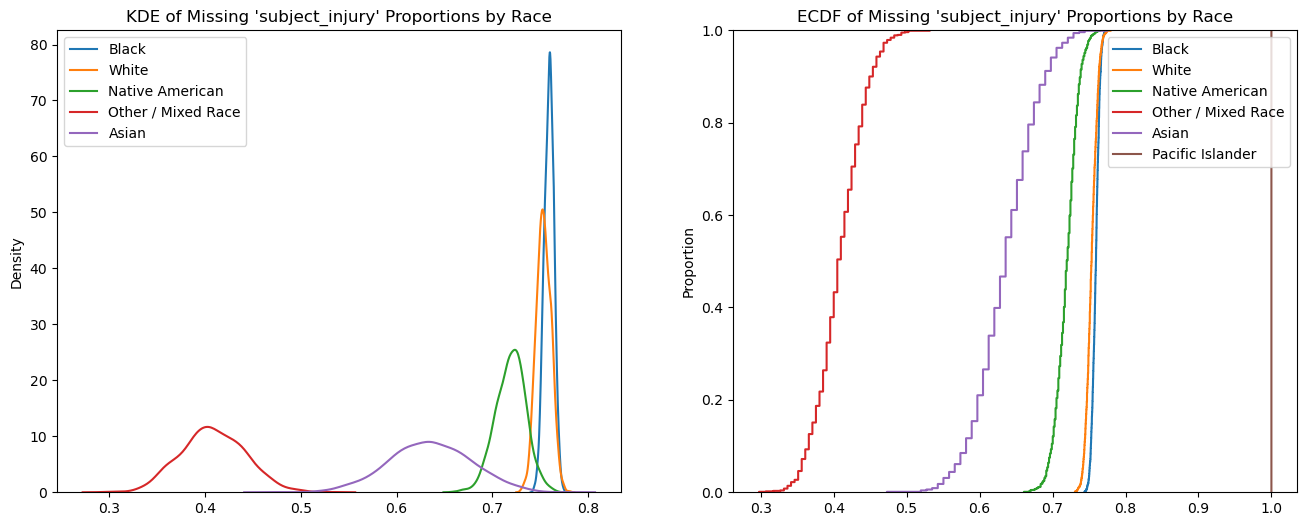

In [ ]:
force_df = pd.read_csv('./data/mn_police_use_of_force.csv')
races = force_df['race'].dropna().unique()

def stat(x):
    stat = x.isna().mean()
    return stat

def simulate1(var, df, fcn, S=1000, plot=True):
    x = df[var]

    estimates = []
    for s in range(S):
        x_s = x.sample(frac=1.0,replace=True)
        stat_s = fcn(x_s)
        estimates.append(stat_s)
    estimates = np.array(estimates)
    return estimates

races = force_df['race'].dropna().unique()
race_estimates = {}

for race in races:
    sub_df = force_df[force_df['race'] == race]
    estimates = simulate1('subject_injury', sub_df, stat, S=1000, plot=False)
    race_estimates[race] = estimates

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for race, estimates in race_estimates.items():
    sns.kdeplot(estimates, label=race, ax=axes[0], warn_singular=False)
axes[0].set_title("KDE of Missing 'subject_injury' Proportions by Race")
axes[0].legend()

for race, estimates in race_estimates.items():
    sns.ecdfplot(estimates, label=race, ax=axes[1])
axes[1].set_title("ECDF of Missing 'subject_injury' Proportions by Race")
axes[1].legend()

plt.show()

Looking at the bootstrapped sampling distributions of missing *subject_injury* proportions by race, it appears as thorugh 'Black' and 'White' groups have the highest estimated rates of missing data, with proportions that look to be around 0.77 and 0.76, respectively. These two groups also have the narrowest KDE curves and steepest ECDFs, indicating that their estimates are highly consistent across bootstrap samples and subject to relatively low second-order uncertainty. In contrast, the 'Other / Mixed Race' and 'Pacific Islander' groups have much wider KDEs and flatter ECDFs, suggesting a greater degree in variability in their bootstrapped estimates. I think the increased uncertainty is porbaly due to smaller sample sizes in these groups, which would lead to more fluctuation when resampling. 

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data. Pick a variable and a statistic to compute (e.g. mean, median, variance, IQR)
- Use the `simulate` function from class to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def stat(x):
    #get the mean
    return np.mean(x)

#simulate function from class w/ added line by line comments
def simulate(var, df, fcn, S=1000, plot=True):
    ''' Bootstrap simulation code. '''    
    #get the column of data specified
    x = df[var]

    #create the empty list of estimates
    estimates = []

    #loop over the number of resamples we want to get
    for s in range(S):
        # Draw a new sample of the whole column we want, with replacement:
        x_s = x.sample(frac=1.0,replace=True)
        # Compute statistic on the new sample:
        stat_s = fcn(x_s)
        # Append estimate:
        estimates.append(stat_s)
    estimates = np.array(estimates) # Convert estimates list to numpy array

    ## or in one line, 
    #estimates = [fcn(x.sample(frac=1.0,replace=True)) for s in range(S)]

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))  # 1 row, 2 columns
        sns.kdeplot(x, ax = axes[0]).set(title='KDE of Underlying Data')
        sns.kdeplot(estimates, ax = axes[1]).set(title='KDE of Computed Statistics')
        axes[1].axvline(x=fcn(x), color='orange', linestyle='--')
        sns.ecdfplot(estimates, ax = axes[2]).set(title='ECDF of Computed Statistics')
        axes[2].axvline(x=fcn(x), color='orange', linestyle='--')
        plt.show()
        print(f'Variance of estimates is: {np.var(estimates)}')
        
    return estimates

/tmp/ipykernel_13456/3872895675.py:1: DtypeWarning: Columns (142) have mixed types. Specify dtype option on import or set low_memory=False.
  nhanes = pd.read_csv('./data/nhanes_data_17_18.csv')


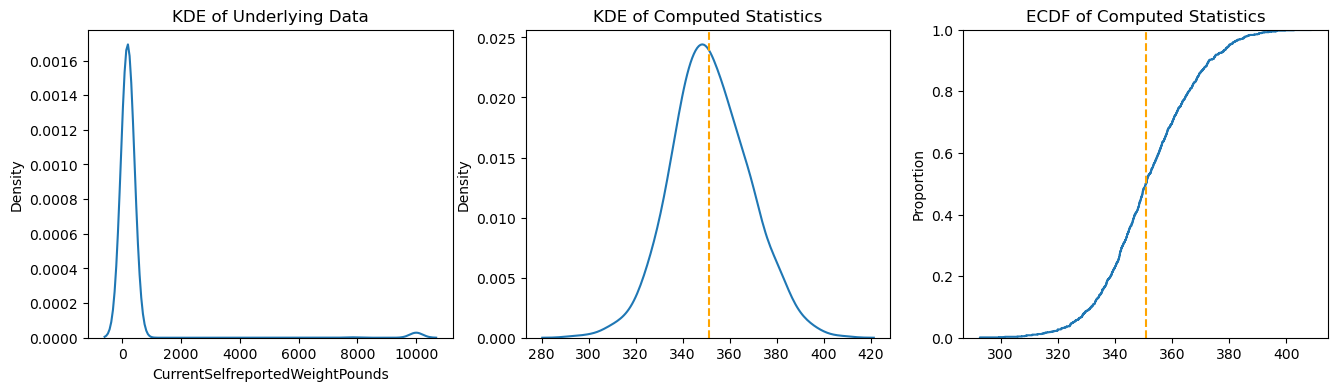

Variance of estimates is: 275.9282289888648


In [6]:
nhanes = pd.read_csv('./data/nhanes_data_17_18.csv')
estimates = simulate('CurrentSelfreportedWeightPounds', nhanes, stat)

In [12]:
def interval(L,H,estimates):
    low = np.quantile(estimates, L)
    high = np.quantile(estimates, H)
    return (low, high)

In [13]:
interval(0.05,0.95,estimates)

(np.float64(325.4965162708607), np.float64(380.0084100961707))

### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

Goal of the Trial: The purpose of the ISCHEMIA-CKD trial is to determine the best management strategy for patients with stable ischemic heart disease 
Plan: They have an invasive strategy where the patients get "cardiac catheterization followed by revascularization (Percutaneous Coronary Intervention or Coronary Artery Bypass Graft Surgery) plus optimal medical therapy." or a conservative strategy where the patients get "Optimal medical therapy with cardiac catheterization and revascularization reserved for patients with OMT failure." Patients were randomly assigned to the interventions 

The invasive strategy has a death rate of 31.7% while the conservative strategy has a rate of 33.2%

In [13]:
data = {
    "strategy": ["Invasive", "Conservative"],
    "population": [388, 389],
    "prop_death": [0.317, 0.332]
}

df_info = pd.DataFrame(data)


rows = []
for _, row in df_info.iterrows():
    n = row["population"]
    n_deaths = int(round(n * row["prop_death"]))
    n_survive = n - n_deaths
    
   
    outcomes = np.array([1]*n_deaths + [0]*n_survive)
    np.random.shuffle(outcomes) 
    
    
    group_df = pd.DataFrame({
        "strategy": row["strategy"],
        "outcome": outcomes
    })
    
    rows.append(group_df)

df = pd.concat(rows, ignore_index=True)
df.head()

,strategy,outcome
0,Invasive,0
1,Invasive,0
2,Invasive,0
3,Invasive,0
4,Invasive,1


In [4]:
def simulate(var, df, fcn, S=1000, plot=True):
    ''' Bootstrap simulation code. '''    
    x = df[var]

    estimates = []
    for s in range(S):
        # Draw a new sample, with replacement:
        x_s = x.sample(frac=1.0,replace=True)
        # Compute statistic:
        stat_s = fcn(x_s)
        # Append estimate:
        estimates.append(stat_s)
    estimates = np.array(estimates) # Convert estimates list to numpy array

    ## or in one line, 
    #estimates = [fcn(x.sample(frac=1.0,replace=True)) for s in range(S)]

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))  # 1 row, 2 columns
        sns.kdeplot(x, ax = axes[0]).set(title='KDE of Underlying Data')
        sns.kdeplot(estimates, ax = axes[1]).set(title='KDE of Computed Statistics')
        axes[1].axvline(x=fcn(x), color='orange', linestyle='--')
        sns.ecdfplot(estimates, ax = axes[2]).set(title='ECDF of Computed Statistics')
        axes[2].axvline(x=fcn(x), color='orange', linestyle='--')
        plt.show()
        print(f'Variance of estimates is: {np.var(estimates)}')
        
    return estimates

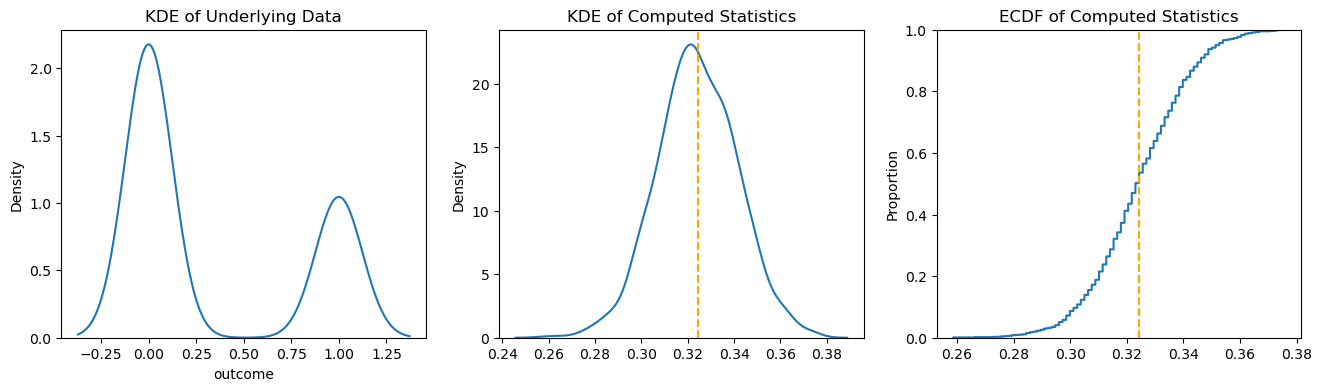

Variance of estimates is: 0.0002956880255876395


In [19]:
var = 'outcome'
def stat(x):
    stat = np.mean(x)
    return stat
estimates = simulate(var, df,stat)

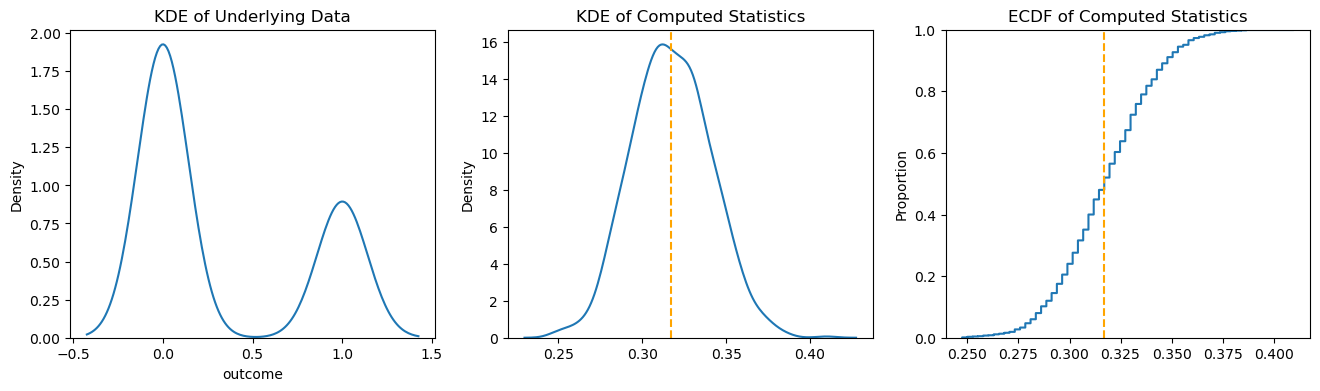

Variance of estimates is: 0.0005505526623445638


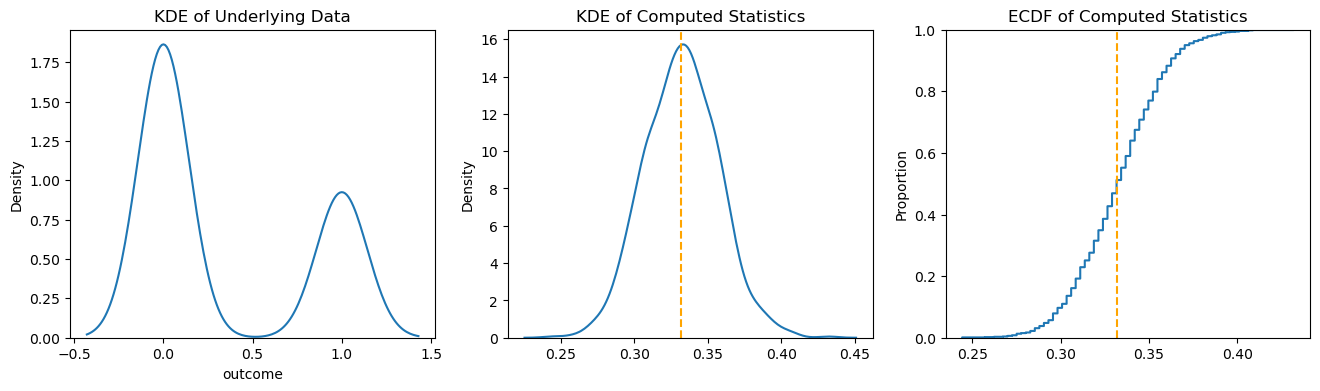

Variance of estimates is: 0.0006209381050878596


In [20]:
invasive_est = simulate('outcome', df[df['strategy']=='Invasive'], stat)
conservative_est = simulate('outcome', df[df['strategy']=='Conservative'], stat)

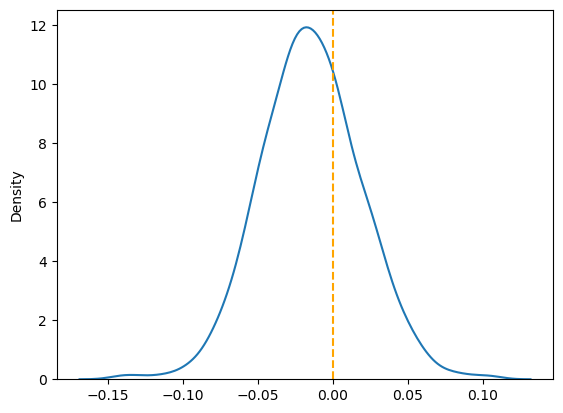

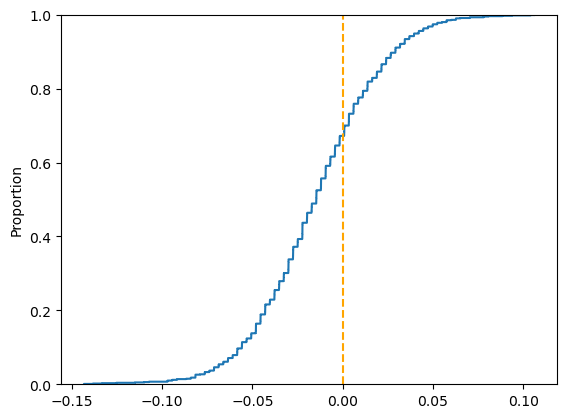

In [22]:
diff_est = invasive_est - conservative_est
sns.kdeplot(diff_est)
plt.axvline(0, color="orange", linestyle="--")
plt.show()
sns.ecdfplot(diff_est)
plt.axvline(0, color="orange", linestyle="--")
plt.show()

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$, and make KDE plots of your results.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
iowa = pd.read_csv("./data/iowa.csv")
xy = (
    iowa.loc[:, ["Bottles Sold", "Sale (Dollars)"]]
        .rename(columns={"Bottles Sold": "x", "Sale (Dollars)": "y"})
        .dropna()
        .astype({"x": float, "y": float})
)
x = xy["x"].to_numpy()
y = xy["y"].to_numpy()

In [ ]:
# Silverman's bandwidth (plugin estimator)
def silverman_bandwidth(x):
    n = len(x)
    std = np.std(x, ddof=1)
    return 1.06 * std * n ** (-1/5)

# Epanechnikov kernel
def epanechnikov(u):
    return 0.75 * (1 - u**2) * (np.abs(u) <= 1)

# Nadaraya-Watson / LCLS estimator with Epanechnikov kernel
def nadaraya_watson(x_train, y_train, x_eval, h=None):
    if h is None:
        h = silverman_bandwidth(x_train)
    estimates = []
    for z in x_eval:
        weights = epanechnikov((z - x_train) / h)
        if weights.sum() > 0:
            y_hat = np.sum(weights * y_train) / np.sum(weights)
        else:
            y_hat = np.nan
        estimates.append(y_hat)
    return np.array(estimates)

x_eval = np.linspace(np.percentile(x, 1), np.percentile(x, 99), 200)

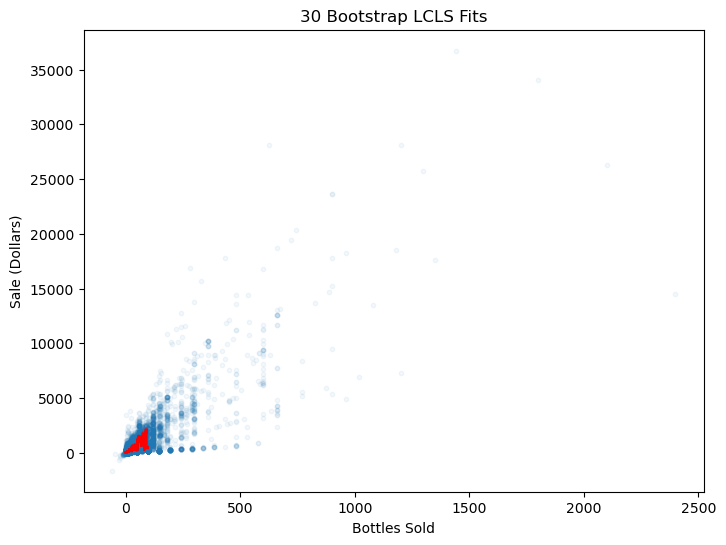

In [4]:
# 1. Bootstrap 30 samples, plot variation in lines

plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.05, s=10, label="Raw Data")

for b in range(30):
    idx = np.random.choice(len(x), size=len(x), replace=True)
    x_boot, y_boot = x[idx], y[idx]
    y_hat = nadaraya_watson(x_boot, y_boot, x_eval)
    plt.plot(x_eval, y_hat, color="red", alpha=0.3)

plt.title("30 Bootstrap LCLS Fits")
plt.xlabel("Bottles Sold")
plt.ylabel("Sale (Dollars)")
plt.show()

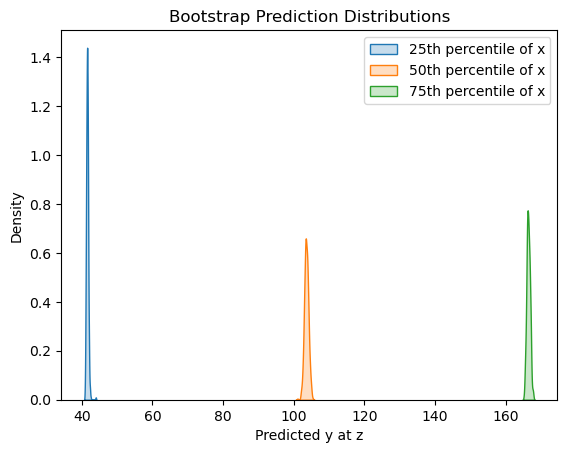

In [ ]:
# 2. Distribution of predictions at specific percentiles

for q in [25, 50, 75]:
    z = np.percentile(x, q)
    preds = []
    for b in range(500):  
        idx = np.random.choice(len(x), size=len(x), replace=True)
        x_boot, y_boot = x[idx], y[idx]
        y_hat = nadaraya_watson(x_boot, y_boot, [z])[0]
        preds.append(y_hat)
    
    sns.kdeplot(preds, fill=True, label=f"{q}th percentile of x")
    
plt.title("Bootstrap Prediction Distributions")
plt.xlabel("Predicted y at z")
plt.legend()
plt.show()

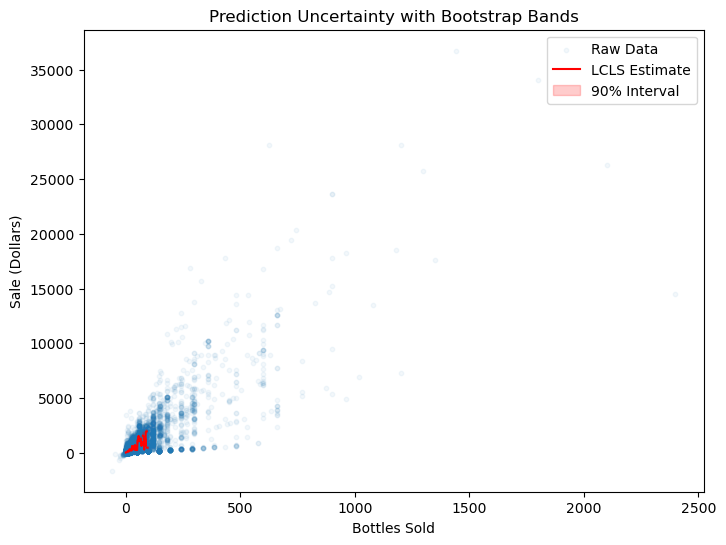

In [ ]:
# 3. Error bands (.05 and .95 quantiles) across grid

all_preds = []
B = 200  # number of bootstraps
for b in range(B):
    idx = np.random.choice(len(x), size=len(x), replace=True)
    x_boot, y_boot = x[idx], y[idx]
    y_hat = nadaraya_watson(x_boot, y_boot, x_eval)
    all_preds.append(y_hat)

all_preds = np.array(all_preds)  

y_hat_main = nadaraya_watson(x, y, x_eval)
lower = np.percentile(all_preds, 5, axis=0)
upper = np.percentile(all_preds, 95, axis=0)

plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.05, s=10, label="Raw Data")
plt.plot(x_eval, y_hat_main, color="red", label="LCLS Estimate")
plt.fill_between(x_eval, lower, upper, color="red", alpha=0.2, label="90% Interval")
plt.title("Prediction Uncertainty with Bootstrap Bands")
plt.xlabel("Bottles Sold")
plt.ylabel("Sale (Dollars)")
plt.legend()
plt.show()

Bootstrapped fits show that predictions are tight and reliable at low-to-moderate sales volumes where data are dense, as reflected by narrow confidence bands and stable KDE distributions at the 25th, 50th, and 75th percentiles. However, uncertainty grows at higher volumes where data are sparse, leading to wider intervals and greater variability in the bootstrap fits, making predictions in this range less reliable.
